In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
data = pd.read_csv('./Data/H1B_2017_.csv', low_memory=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622773 entries, 0 to 622772
Data columns (total 13 columns):
Unnamed: 0              622773 non-null int64
employer                622773 non-null object
job_title               622773 non-null object
occupational_name       622773 non-null object
prevailing_wage         622773 non-null float64
pw_wage_period          622773 non-null object
employer_wage           622773 non-null float64
employer_max_wage       622773 non-null float64
employer_wage_period    622773 non-null object
city                    622773 non-null object
county                  622773 non-null object
state                   622773 non-null object
postal_code             622773 non-null object
dtypes: float64(3), int64(1), object(9)
memory usage: 61.8+ MB


In [4]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,employer,job_title,occupational_name,prevailing_wage,pw_wage_period,employer_wage,employer_max_wage,employer_wage_period,city,county,state,postal_code
0,DISCOVER PRODUCTS INC.,ASSOCIATE DATA INTEGRATION,COMPUTER SYSTEMS ANALYSTS,59197.0,Year,65811.0,67320.0,Year,RIVERWOODS,LAKE,IL,60015
1,DFS SERVICES LLC,SENIOR ASSOCIATE,OPERATIONS RESEARCH ANALYSTS,49800.0,Year,53000.0,57200.0,Year,RIVERWOODS,LAKE,IL,60015
2,INFO SERVICES LLC,PROJECT MANAGER,"COMPUTER OCCUPATIONS, ALL OTHER",90376.0,Year,102000.0,0.0,Year,JERSEY CITY,HUDSON,NJ,07302
3,BB&T CORPORATION,ASSOCIATE - ESOTERIC ASSET BACKED SECURITIES,CREDIT ANALYSTS,116605.0,Year,132500.0,0.0,Year,NEW YORK,NEW YORK,NY,10036
4,"SUNTRUST BANKS, INC.",CREDIT RISK METRICS SPECIALIST,"FINANCIAL SPECIALISTS, ALL OTHER",59405.0,Year,71750.0,0.0,Year,ATLANTA,FULTON,GA,30303


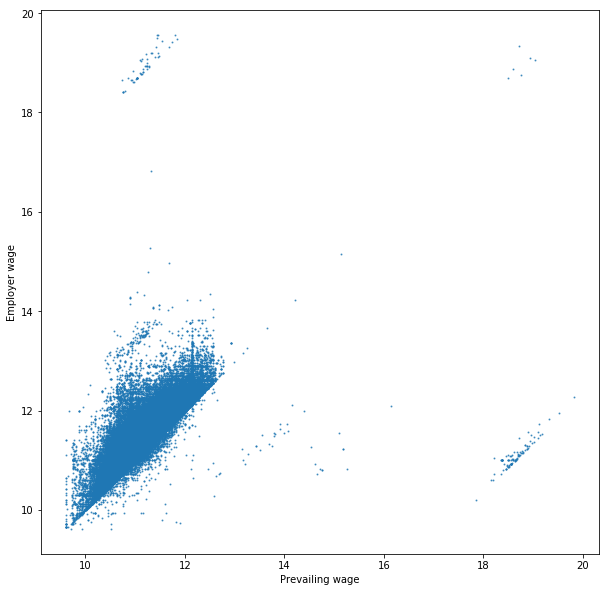

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(np.log(data.prevailing_wage), np.log(data.employer_wage), alpha=0.7, s=1)
plt.xlabel('Prevailing wage')
plt.ylabel('Employer wage')
plt.show()

In [65]:
# Selecting possible features to train model
columns = ['job_title', 'occupational_name', 'prevailing_wage', 'city', 'county', 'state', 'postal_code']
features = data[columns]
# Selecting possible targets
y_emp = data.employer_wage

In [8]:
for col in columns:
    print("Number of unique values for column -{}- : {}".format(col, len(features[col].unique())))
print("Number of unique values for column -prevailing_wage- : {}".format(len(y_pr.unique())))
print("Number of unique values for column -employer_wage- : {}".format(len(y_emp.unique())))

Number of unique values for column -job_title- : 92756
Number of unique values for column -occupational_name- : 865
Number of unique values for column -prevailing_wage- : 24052
Number of unique values for column -city- : 9348
Number of unique values for column -county- : 3676
Number of unique values for column -state- : 57
Number of unique values for column -postal_code- : 14923
Number of unique values for column -prevailing_wage- : 24052
Number of unique values for column -employer_wage- : 50655


When a user wants to predict the employer's wage most likely he will not know the prevailing wage for his future position. To remediate this issue and make more robust the model, I propose to train part of the data to predict the prevailing wage and then use the rest of the data to predict the final salary. The data points are going to be selected randomly by index number in the data set.

In [66]:
indeces = np.arange(0, len(data))
# set seed for the rest of the project
seed = 14
np.random.seed(seed)
# shuffle indexes
random_index = np.random.permutation(indeces)

In [74]:
# Data for prevailing wage prediction
X_pr = features.iloc[random_index[:int(len(data)/2)]].reset_index(drop=True)
y_pr = np.log(X_pr.prevailing_wage)
X_pr.drop(['prevailing_wage'], axis=1, inplace=True)

We intend to predict the prevailing wage using words, so per row the columns are going to be merged into one and a vectorizer is going to be created. The data being to big we need to train the model by batches. Given the amount of data, the proper model to use is an SDG Regressor.

In [160]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error
from time import time

# Merging columns per row
X_pr['merged'] = X_pr.job_title + " " + X_pr.occupational_name + " " + X_pr.city \
                    + " " + X_pr.county + " " + X_pr.state + " " + X_pr.postal_code
# Create vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_pr.merged)
# Creating testing and training sets
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr.merged, y_pr, test_size=0.25, random_state=seed)
# Change Xs to vectorized form
X_train_pr_vec = vectorizer.transform(X_train_pr).tocsc()
X_test_pr_vec = vectorizer.transform(X_test_pr).tocsc()

In [163]:
regressor1 = SGDRegressor(penalty='l2', random_state=seed)
regressor2 = LinearRegression()

for regressor in [regressor1, regressor2]:
    # Train model
    start = time()
    regressor.fit(X_train_pr_vec, y_train_pr)
    end = time()
    regressor_name = regressor.__class__.__name__
    print("%s training time: %.3fs" %(regressor_name, end-start))
    y_pred_pr = regressor.predict(X_test_pr_vec)
    mean_error = mean_absolute_error(y_pred_pr, y_test_pr)
    print("{} mean absolute error: {}".format(regressor_name, mean_error))

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor training time: 0.295s
SGDRegressor mean absolute error: 0.5691489144815631
LinearRegression training time: 81.950s
LinearRegression mean absolute error: 0.15349871852210237


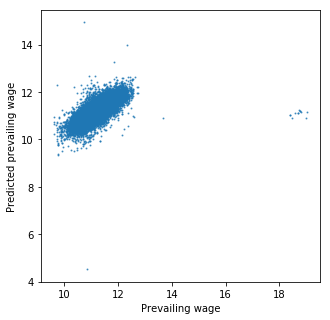

In [175]:
plt.figure(figsize=(5,5))
plt.scatter(y_test_pr, y_pred_pr, alpha=0.7, s=1)
plt.xlabel('Prevailing wage')
plt.ylabel('Predicted prevailing wage')
plt.show()

For comparison let's make the training on the employer's wage.

In [170]:
# Get employer wage
y_pr_em = np.log(y_emp.iloc[random_index[:int(len(data)/2)]].reset_index(drop=True))
# Creating testing and training sets
X_train_pr_em, X_test_pr_em, y_train_pr_em, y_test_pr_em = train_test_split(X_pr.merged, y_pr_em, \
                                                                            test_size=0.25, random_state=seed)
# Change Xs to vectorized form
X_train_pr_em_vec = vectorizer.transform(X_train_pr_em).tocsc()
X_test_pr_em_vec = vectorizer.transform(X_test_pr_em).tocsc()

In [171]:
regressor1_ = SGDRegressor(penalty='l2', random_state=seed)
regressor2_ = LinearRegression()

for regressor in [regressor1, regressor2]:
    # Train model
    start = time()
    regressor.fit(X_train_pr_em_vec, y_train_pr_em)
    end = time()
    regressor_name = regressor.__class__.__name__
    print("%s training time: %.3fs" %(regressor_name, end-start))
    y_pred_pr_em = regressor.predict(X_test_pr_em_vec)
    mean_error = mean_absolute_error(y_pred_pr_em, y_test_pr_em)
    print("{} mean absolute error: {}".format(regressor_name, mean_error))

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor training time: 0.294s
SGDRegressor mean absolute error: 0.5807219466076828
LinearRegression training time: 79.603s
LinearRegression mean absolute error: 0.16241678753405822


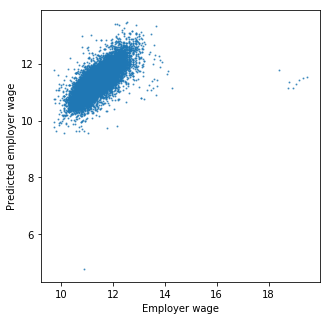

In [174]:
plt.figure(figsize=(5,5))
plt.scatter(y_test_pr_em, y_pred_pr_em, alpha=0.7, s=1)
plt.xlabel('Employer wage')
plt.ylabel('Predicted employer wage')
plt.show()

Now we are going to use the other half of the data to make predictions on wage salary by two methods and compare them. We are going to predict the employer's wage using the state, postal_code and prevailing_wage fields but for the prevealing wage we are going to consider first the one from the data and then the one predicted by the first model from trained on the words.

Let's get first the second half of the data from the original dataset.

In [240]:
# Data for employer wage prediction
X_em = features.iloc[random_index[int(len(data)/2)]:].reset_index(drop=True)
X_em.prevailing_wage = np.log(X_em.prevailing_wage)
X_em_full = X_em.copy()
X_em.drop(['job_title', 'occupational_name', 'city', 'county'], axis=1, inplace=True)
# Employer wage
y_em = np.log(y_emp.iloc[random_index[int(len(data)/2)]:].reset_index(drop=True))

In [228]:
X_em.head()

,prevailing_wage,state,postal_code
0,10.931499,NJ,07306
1,11.069914,UT,84111
2,11.260997,NJ,08534
3,11.359774,OH,44321
4,10.994572,VA,23230


The amount of data being significant, first we define a function creating batches for training.

In [200]:
def batches(size, X, y):
    # This function transform data to be trained into batches
    batch_start = 0
    n_points = X.shape[0]
    while batch_start < n_points:
        batch_end = batch_start + size
#         X_batch = pd.get_dummies(X.iloc[range(batch_start, batch_end)], \
#                                  columns=['postal_code','state'], drop_first=True)
        if batch_end < n_points:
            X_batch = X.iloc[range(batch_start, batch_end)]
            y_batch = y.iloc[range(batch_start, batch_end)]
        else:
            X_batch = X.iloc[range(batch_start,n_points)]
            y_batch = y.iloc[range(batch_start, n_points)]
        yield X_batch, y_batch
        batch_start += size
        
        #permutation with np.random.permutation in indexes

First let's predict employer wages with prevailing wage from data set. For this part, the state and postal_code columns being of categorical type, it is necessary to use one-hot encoding.

In [207]:
from dummyPy import OneHotEncoder

# Create one-hot encoder and fit it to the data
encoder = OneHotEncoder(['postal_code', 'state'])
encoder.fit(X_em)
# Set parameters for batch training
batch_size = 20000
regressor_wage = SGDRegressor(random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(X_em, y_em, test_size=0.25, random_state=seed)

# Get batches
train_batches = batches(batch_size, X_train, y_train)

# Start training
start = time() #start time
for X_batch, y_batch in train_batches:
    X_batch_trans = encoder.transform(X_batch)
    regressor_wage.partial_fit(X_batch_trans, y_batch)
end = time() #end time

regressor_name = regressor_wage.__class__.__name__
print("%s training time: %.3fs" %(regressor_name, end-start))

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor training time: 652.153s


In [208]:
# Predict on test set
test_batches = batches(batch_size, X_test, y_test)
y_pred_wage = []
for X_tbatch, y_tbatch in test_batches:
    X_test_trans = encoder.transform(X_tbatch)
    y_pred_wage.extend(regressor_wage.predict(X_test_trans))
    
# Calculate mean absolute error
mean_error = mean_absolute_error(y_pred_wage, y_test)
print("{} mean absolute error: {}".format(regressor_name, mean_error))

SGDRegressor mean absolute error: 0.11503581653320731


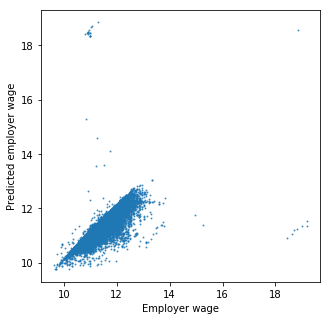

In [209]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_wage, alpha=0.7, s=1)
plt.xlabel('Employer wage')
plt.ylabel('Predicted employer wage')
plt.show()

Now let's predict prevailing wage from word model.

In [242]:
# Merged categotical columns per row
X_em_full['merged'] = X_em_full.job_title + " " + X_em_full.occupational_name + " " \
                        + X_em_full.city + " " + X_pr.county + " " + X_pr.state \
                        + " " + X_pr.postal_code
# Predict prevailing wage and add to X_em
#X_em['pred_prevailing_wage'] = regressor1.predict(vectorizer.transform(X_em_full.merged))

In [253]:
X_em_full.tail()

,job_title,occupational_name,prevailing_wage,city,county,state,postal_code,merged
357812,SENIOR JAVA DEVELOPER,"SOFTWARE DEVELOPERS, APPLICATIONS",11.254279,DUBLIN,FRANKLIN,OH,43017,NaN
357813,POSTDOCTORAL ASSOCIATE,PHYSICISTS,10.827707,CAMBRIDGE,MIDDLESEX,MA,02139,NaN
357814,RESEARCH SCIENTIST,"GEOSCIENTISTS, EXCEPT HYDROLOGISTS AND GEOGRAP...",11.019760,CAMBRIDGE,MIDDLESEX,MA,02139,NaN
357815,POSTDOCTORAL ASSOCIATE,MATERIALS ENGINEERS,10.630843,CAMBRIDGE,MIDDLESEX,MA,02139,NaN
357816,EVENTS AND INCENTIVES COORDINATOR,"MEETING, CONVENTION, AND EVENT PLANNERS",10.718808,BEVERLY HILLS,LOS ANGELES,CA,90210,NaN


In [213]:
X_em_full.head()

,prevailing_wage,state,postal_code
0,10.931499,NJ,07306
1,11.069914,UT,84111
2,11.260997,NJ,08534
3,11.359774,OH,44321
4,10.994572,VA,23230


In [ ]:
use_columns = ['pred_prevailig_wage', 'state', 'postal_code']
X_train, X_test, y_train, y_test = train_test_split(X_em[use_columns], y_em, test_size=0.25, random_state=seed)

# Get batches
train_batches = batches(batch_size, X_train, y_train)
# Initialize regressor
regressor_wage_pred_pr = SGDRegressor(random_state=seed)
# Start training
start = time() #start time
for X_batch, y_batch in train_batches:
    X_batch_trans = encoder.transform(X_batch)
    regressor_wage_pred_pr.partial_fit(X_batch_trans, y_batch)
end = time() #end time

regressor_name = regressor_wage.__class__.__name__
print("%s training time: %.3fs" %(regressor_name, end-start))

In [ ]:
# Predict on test set
test_batches = batches(batch_size, X_test, y_test)
y_pred_wage = []
for X_tbatch, y_tbatch in test_batches:
    X_test_trans = encoder.transform(X_tbatch)
    y_pred_wage.extend(regressor_wage.predict(X_test_trans))
    
# Calculate mean absolute error
mean_error = mean_absolute_error(y_pred_wage, y_test)
print("{} mean absolute error: {}".format(regressor_name, mean_error))

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_wage, alpha=0.7, s=1)
plt.xlabel('Employer wage')
plt.ylabel('Predicted employer wage')
plt.show()

In [ ]:
# Predict on test set
for X_tbatch, y_tbatch in test_batches:
    X_test_trans = encoder.transform(X_tbatch)
    y_pred_wage.append(regressor.predict(X_test_trans))
# Calculate mean absolute error
mean_error = mean_absolute_error(y_pred_wage, y_test)
print("{} mean absolute error: {}".format(regressor_name, mean_error))

In [23]:

#training_score = regressor.score(X_train, y_train)
test_batches = batches(batch_size, X_test, y_test)
test_score = 0
mean_error = 0
i = 0
y_pred = []
for X_tbatch, y_tbatch in test_batches:
    X_test_trans = encoder.transform(X_tbatch)
    test_score += regressor.score(X_test_trans, y_tbatch)
    y_pred.append(regressor.predict(X_test_trans))
    mean_error += mean_absolute_error(y_tbatch, y_pred)
    i += 1
print("%s R^2 test score: %.4f" %(regressor_name, test_score/i))
print("{} mean absolute error: {}".format(regressor_name, mean_error/i))

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor training time: 1375.546s
SGDRegressor R^2 test score: 0.6263
SGDRegressor mean absolute error: 0.1363211370272472


/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


PassiveAggressiveRegressor training time: 1381.769s
PassiveAggressiveRegressor R^2 test score: -3.6214
PassiveAggressiveRegressor mean absolute error: 0.7543280838693444


In [28]:
regressor_1 = SGDRegressor(random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.25, random_state=random_state)
iterator = batches(batch_size, X_train, y_train)
for regressor in [regressor_1]:
    start = time() #start time
    for X_batch, y_batch in iterator:
        regressor.partial_fit(X_batch, y_batch)
    end = time() #end time
    
    regressor_name = regressor.__class__.__name__
    #training_score = regressor.score(X_train, y_train)
    test_score = regressor.score(X_test, y_test)
    print("%s training time: %.3fs" %(regressor_name, end-start))
    #print("%s R^2 training score: %.4f" %(regressor_name, training_score))
    print("%s R^2 test score: %.4f" %(regressor_name, test_score))
    y_pred = regressor.predict(X_test)
    mean_error = mean_absolute_error(y_test, y_pred)
    print("Mean absolute error: {}".format(mean_error))

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


MemoryError: 

In [ ]:
encoder.transform(X[:4])

In [ ]:
X__ = X_.drop(['city'], axis=1)

In [ ]:
pd.get_dummies(X, columns=['county'], drop_first=True)

In [ ]:
np.sum(X.employer.value_counts() <= 10)

In [ ]:
pd.get_dummies(X, columns=['postal_code'], drop_first=True)